### Phase-based encoding in pairwise neural interactions

In [1]:
import os

In [2]:
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate_kuramoto

In [4]:
structure = "visual"

In [5]:
dt = 0.001  # Integration time-step
fs = 1 / dt
f = 40  # Natural frequency
beta = 3.5  # Noise variance
if structure == "chain":
    A = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T
    D = np.zeros_like(A)
elif structure == "collider":
    A = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 0]]).T
    D = np.zeros_like(A)
elif structure == "visual":
    SC_data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()
    # FLN matrix
    A = SC_data["FLN"][np.ix_([0, 1, 2], [0, 1, 2])]
    # Distance matrix
    D = SC_data["Distances"] * 0 * 1e-3 / 3.5
    D /= dt
    D = D[np.ix_([0, 1, 2], [0, 1, 2])]

ntrials = 500
time = np.arange(-0.5, 1, 1 / fs)  # Time array
T = time.shape[0]

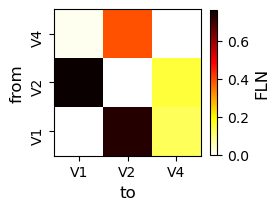

In [6]:
if structure == "visual":
    plt.figure(figsize=(6 / 2.54, 6 / 2.54))
    plt.imshow(A, origin="lower", cmap="hot_r")
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label("FLN", fontsize=12)
    plt.xticks([0, 1, 2], ["V1", "V2", "V4"])
    plt.yticks([0, 1, 2], ["V1", "V2", "V4"], rotation=90)
    plt.xlabel("to", fontsize=12)
    plt.ylabel("from", fontsize=12)
    plt.savefig("figures/visual_conn.png", bbox_inches="tight")

In [7]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.4
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [8]:
data = []
for trial in tqdm(range(ntrials)):
    data += [
        simulate_kuramoto(
            30 * A, D, coupling * CS[trial], f, fs, beta, T, seed=seeds[trial], decim=1
        )
    ]

100%|█████████████████████████████████████████| 500/500 [00:40<00:00, 12.38it/s]


(600.0, 900.0)

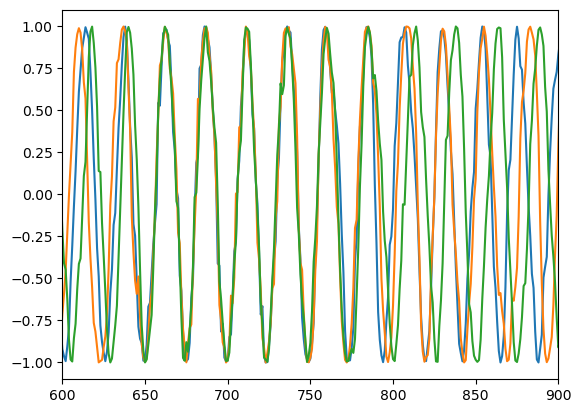

In [9]:
plt.plot(data[-1].T)
plt.xlim(600, 900)

In [10]:
h = scipy.signal.hilbert(np.stack(data).real, axis=2)

In [11]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    fs / 1,
    freqs,
    n_cycles=freqs / 2,
    decim=1,
    output="complex",
    verbose=None,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


In [12]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

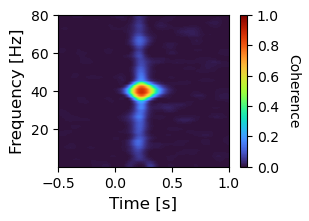

In [13]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
    vmax=1,
)
cbar = plt.colorbar()
cbar.set_label("Coherence", rotation=270, labelpad=15)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/coherece2nodes.pdf")

In [14]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [15]:
e1 = W[:, 0] * np.conj(W[:, 1])
e2 = W[:, 1] * np.conj(W[:, 2])
e3 = W[:, 0] * np.conj(W[:, 2])


dphi = jnp.stack((e1.real, e1.imag, e2.real, e2.imag, e3.real, e3.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, ntrials), (1, 2)), (e1.shape[1], e2.shape[2])
);

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [16]:
MI_PHI = mi_fcn_time_frequency(dphi, labels[None], False, True)

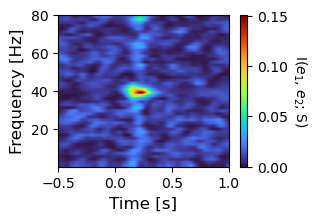

In [17]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))

plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
)
cbar = plt.colorbar()
cbar.set_label(r"I($e_1$, $e_2$; S)", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/MI2nodes.pdf")

#### Synergy and Redundancy

In [18]:
dphi1 = jnp.stack((e1.real, e1.imag))
dphi2 = jnp.stack((e2.real, e2.imag))
dphi3 = jnp.stack((e3.real, e3.imag))
dphi123 = jnp.stack((e1.real, e1.imag, e2.real, e2.imag, e3.real, e3.imag))

In [19]:
mi1 = mi_fcn_time_frequency(dphi1, labels[None], False, False)
mi2 = mi_fcn_time_frequency(dphi2, labels[None], False, False)
mi3 = mi_fcn_time_frequency(dphi3, labels[None], False, False)
mi123 = mi_fcn_time_frequency(dphi123, labels[None], False, False)

In [20]:
red = mi123 - np.minimum(np.minimum(mi1, mi2), mi3)
syn = mi123 - np.maximum(np.maximum(mi1, mi2), mi3)

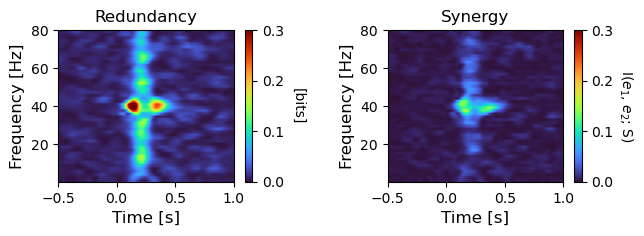

In [21]:
plt.figure(figsize=(18 / 2.54, 5 / 2.54))

plt.subplot(121)

plt.imshow(
    red,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
    vmax=0.3,
)
cbar = plt.colorbar()
cbar.set_label(r"[bits]", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.title("Redundancy", fontsize=12)

plt.subplot(122)

plt.imshow(
    syn,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
    vmax=0.3,
)
cbar = plt.colorbar()
cbar.set_label(r"I($e_1$, $e_2$; S)", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.title("Synergy", fontsize=12)

plt.subplots_adjust(wspace=0.5)

plt.savefig(f"figures/{structure}_syn_red.pdf")